# cfos_batch_combination_20201125_gallery
The notebook provides a gallery of c-fos fixed-batch and fixed-condition comparison plots.

## Table of Contents (click links to skip right to the plots):
* [Fixed batch comparison (Telencephalon, Diencephalon, Mesencephalon)](#fixed_batch_bigdiv)

* [Fixed batch comparison (subregions of Telencephalon, Diencephalon, Mesencephalon)](#fixed_batch_meddiv)

* [Fixed condition comparison (Telencephalon, Diencephalon, Mesencephalon)](#fixed_condition_bigdiv)
* [Fixed condition comparison (subregions of Telencephalon, Diencephalon, Mesencephalon)](#fixed_condition_meddiv)

In [33]:
import pandas as pd
import json
import numpy as np
import matplotlib.pyplot as plt
import edt
import seaborn as sns
import graphviz

%matplotlib inline

## Data loading and validation

In [34]:
main_file = '../data/animals_eroded_counts_20201125.csv' # cleaned of obvious outliers
pma_segment_props_file = '../data/pma_segment_properties_info'
pma_ontology_json_file = '../data/PMA_ontology.json'
pivot_table_file = '../data/pivot_20201125.csv'

In [35]:
# Read in the new dataframe containing cell counts in each PMA brain region
main_df = pd.read_csv(main_file)
main_df

,brain,brain_longname,condition,batch,root,Midbrain,Oculomotor nucleus,Medial terminal nucleus of the accessory optic tract,Lateral terminal nucleus of the accessory optic tract,Dorsal terminal nucleus of the accessory optic tract,...,supraoptic commissures,fasciculus retroflexus,habenular commissure,stria medullaris,nigrostriatal tract,rubrospinal tract,ventral tegmental decussation,crossed tectospinal pathway,direct tectospinal pathway,doral tegmental decussation
0,an011,an011,acquisition_day1,202010_cfos,0,13350,0,34,29,24,...,22,57,0,90,95,508,41,27,0,3
1,an012,an012,acquisition_day1,202010_cfos,0,11361,22,40,14,93,...,120,64,0,79,183,387,36,40,0,4
2,an013,an013,acquisition_day1,202010_cfos,1,12563,11,68,39,5,...,26,26,1,68,71,352,26,29,0,1
3,an014,an014,acquisition_day1,202010_cfos,2,12554,3,28,62,98,...,53,70,0,83,109,197,18,51,0,0
4,an015,an015,acquisition_day1,202010_cfos,2,11431,2,20,8,4,...,38,20,1,73,53,421,23,50,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
164,an30_crus1_lat,an30_crus1_lat,Vehicle_control_reversal,202002_cfos,3,32942,2,216,98,427,...,88,28,3,47,122,864,92,67,0,0
165,an31_crus1_lat,an31_crus1_lat,Vehicle_control_reversal,202002_cfos,1,33377,9,108,162,324,...,85,14,0,97,110,1249,188,96,0,9
166,an32_crus1_lat,an32_crus1_lat,Vehicle_control_reversal,202002_cfos,7,36458,2,208,167,199,...,114,25,4,249,224,1657,94,157,0,4
167,an33_crus1_lat,an33_crus1_lat,Vehicle_control_reversal,202002_cfos,4,29123,4,59,128,481,...,94,39,3,29,90,978,56,107,0,2


In [36]:
# Read in the new dataframe containing cell counts in each PMA brain region
pivot_df = pd.read_csv(pivot_table_file)
pivot_df

,condition,201810_adultacutePC_ymaze_cfos,201904_ymaze_cfos,201908_tpham_ymaze_cfos,202002_cfos,202010_cfos
0,CNO_control_no_reversal,0,8,0,0,0
1,CNO_control_reversal,0,10,7,5,0
2,CNOnCrusILT,0,0,8,10,0
3,CNOnCrusIRT,0,0,9,10,0
4,Vehicle_control_reversal,0,0,0,9,0
5,acquisition_day1,0,0,0,0,10
6,acquisition_day2,0,0,0,0,10
7,cno_injection,0,0,0,3,0
8,crusI_bilateral_reversal,6,0,0,0,0
9,dilutedvector_control_reversal,0,0,0,14,0


In [37]:
batches = main_df['batch'].unique()
conditions = main_df['condition'].unique()

In [38]:
with open(pma_ontology_json_file,'r') as infile:
    pma_ontology_dict = json.load(infile)

As always we need our get_progeny() function to get the list of all descendents of a brain region

In [39]:
def get_progeny(dic,parent_structure,progeny_list):
    """ 
    ---PURPOSE---
    Get a list of all progeny of a structure name.
    This is a recursive function which is why progeny_list is an
    argument and is not returned.
    ---INPUT---
    dic                  A dictionary representing the JSON file 
                         which contains the ontology of interest
    parent_structure     The structure
    progeny_list         The list to which this function will 
                         append the progeny structures. 
    """
    name = dic.get('name')
    children = dic.get('children')
    if name == parent_structure:
        for child in children: # child is a dict
            child_name = child.get('name')
            progeny_list.append(child_name)
            get_progeny(child,parent_structure=child_name,progeny_list=progeny_list)
        return
    
    for child in children:
        child_name = child.get('name')
        get_progeny(child,parent_structure=parent_structure,progeny_list=progeny_list)
    return

We also need a function to get total counts from a given region for a given brain. 

In [40]:
def get_total_counts(soi,series,debug=False):
    """ Get the total counts in a region
    and all of its descendent regions 
    from a single dataframe series (single brain)
    
    ---INPUT---
    soi    region name of interest
    seires pandas series representing a row (single brain) from the main dataframe
    ---OUTPUT---
    total  the total number of summed
    """
    
    progeny_list=[]
    get_progeny(pma_ontology_dict,parent_structure=soi,progeny_list=progeny_list)
    total=0 #store counts in this list
    # Add the counts for the region itself, if that region is in the dataframe
    try:
        total+=series[soi]
        if debug:
            print(f"{soi} is in dataframe!")
    except:
        if debug:
            print(f"{soi} not in dataframe")
        pass
    for progen in progeny_list:
        try:
            
            count = int(series[progen])
            if debug:
                print(f"{progen} is in dataframe!")
            total+=count    
        except:
            if debug:
                print(f"{progen} not in dataframe")
            pass
    return total

Here is where things diverge from previous notebooks. In the past, we have made a custom dictionary up here and then used this in all of the scripts below. Instead, we want to be able to feed a list of brain regions into the scripts below.

In [41]:
def get_fractional_counts(soi,series,normalizing_counts,debug=False):
    """ Get the fractional counts in a region
    and all of its descendent regions.
    
    ---INPUT---
    soi                 region name of interest
    seires              pandas series representing a row (single brain) from the main dataframe
    normalizing_counts  The total counts to use as the denominator for calculating the fraction 
    ---OUTPUT---
    The fractional count of the single soi out of the entire Telencephalon, Diencephalon, Mesencephalon
    """
    
    progeny_list=[]
    get_progeny(pma_ontology_dict,parent_structure=soi,progeny_list=progeny_list)
    total=0 #store counts in this list
    # Add the counts for the region itself, if that region is in the dataframe
    try:
        total+=series[soi]
        if debug:
            print(f"{soi} is in dataframe!")
    except:
        if debug:
            print(f"{soi} not in dataframe")
        pass
    for progen in progeny_list:
        try:
            count = int(series[progen])
            if debug:
                print(f"{progen} is in dataframe!")
            total+=count    
        except:
            if debug:
                print(f"{progen} not in dataframe")
            pass
    return total/normalizing_counts

# Helper scripts for plots

In [42]:
# helper functions for plots below
def get_counts_dict(brain_division_dict,batch,condition,count_type):
    """ 
    ---PURPOSE---
    Given a batch and condition, calculate either the total or fractional
    counts in each region for each animal in this batch/condition combo
    in the main dataframe  
    ---INPUT---
    batch          The "experiment" column of the main dataframe
    condition      The "Condition" column of the main dataframe
    count_type     if 'frac' plots using fractional counts. 
                   if 'total' plots using total counts
    ---OUTPUT---
    counts_dict    dictionary[brain][division] = count
    """
    assert count_type in ['frac','total']
    assert batch in main_df['batch'].unique()
    assert condition in main_df['condition'].unique()
    batch_mask = main_df['batch'] == batch
    condition_mask = main_df['condition'] == condition
    comb_mask = np.logical_and(batch_mask,condition_mask)
    batch_condition_df = main_df[comb_mask]
    n_animals = len(batch_condition_df)
    # make a dictionary where keys are Brain names and values are dictionaries mapping brain division
    # to either fractional or total counts
    counts_dict = {}
    for index,brain_series in batch_condition_df.iterrows():
        brain = brain_series['brain']
        # Figure out sum of all regions in the brain division dict to provide normalization
        normalizing_counts = 0
        for division in brain_division_dict:
            brain_regions = brain_division_dict[division]
            total_counts = sum([get_total_counts(region,brain_series) for region in brain_regions])
            normalizing_counts += total_counts

        counts_dict[brain] = {}
        for division in brain_division_dict:
            subregions = brain_division_dict[division]
            if count_type == 'frac':
                counts = [get_fractional_counts(soi,brain_series,normalizing_counts) for soi in subregions]
            elif count_type == 'total':
                counts = [get_total_counts(soi,brain_series) for soi in subregions]
            counts_dict[brain][division] = sum(counts)
    return counts_dict


def create_division_df(brain_division_dict,batch,condition,count_type='frac'):
    """ 
    ---PURPOSE---
    Given a batch and condition create a pandas DataFrame
    containing columns: Brain, Batch, Condition and The major divisions.
    ---INPUT---
    batch          The "experiment" column of the main dataframe
    condition      The "Condition" column of the main dataframe
    count_type     if 'frac' plots using fractional counts. 
                   if 'total' plots using total counts
    """
    counts_dict = get_counts_dict(brain_division_dict,batch,condition,count_type)

    counts_by_division = []
    for brain in counts_dict:
        division_dict = {'brain':brain}
        for division in counts_dict[brain]:
            division_dict[division] = counts_dict[brain][division]
        counts_by_division.append(division_dict)
    df = pd.DataFrame(counts_by_division)
    df = df.assign(batch=batch,condition=condition)
    return df

# Plotting functions

In [43]:
legend_fontsize=9

def make_stripplot_fixed_batch(brain_division_dict,count_type='frac',savename=None):
    """ 
    ---PURPOSE---
    For each batch, make a subplot 
    comparing either fractional or total counts in different conditions
    at fixed batch 
    ---INPUT---
    count_type     if 'frac' plots using fractional counts. 
                   if 'total' plots using total counts
    savename       if provided, will save the figure using this filename
    ---OUTPUT---
    ax             returns a matplotlib axis object
    """
    fig, axes = plt.subplots(1, len(batches), figsize=(20, 5), sharey=True)
    fig.suptitle("Batch",fontsize=18,y=1.05)
    for ii,batch in enumerate(batches):
        # figure out which conditions were used in this batch
        condition_list = pivot_df['condition'][pivot_df[batch]>0]
        df_list = []
        
        for condition in condition_list:
            df_by_division = create_division_df(brain_division_dict=brain_division_dict,
                                                batch=batch,
                                                condition=condition,
                                                count_type=count_type)
            df_list.append(df_by_division)
        cdf = pd.concat(df_list)   

        cdf.drop(['brain','batch'],axis=1,inplace=True)
        mdf = pd.melt(cdf, id_vars=['condition'], var_name=['Brain division'])
        if count_type == 'frac':
            value_label = 'fraction of counts'
        elif count_type == 'total':
            value_label = 'total counts'
        title = batch
        mdf.rename(columns={'value':value_label},inplace=True)

        sns.set_theme(style="whitegrid",context="notebook")
        sns.despine(bottom=True, left=True)
        ax=axes[ii]
        sns.stripplot(ax=ax,y=value_label, x='Brain division', 
                           data=mdf, 
                           jitter=True,
                           dodge=True,
                           marker='o', 
                           alpha=0.4,
                           s=8,
                           hue='condition')

        ax.set_title(title,fontsize=14)
        _=plt.setp(ax.get_xticklabels(), rotation=75, ha="right",
                 rotation_mode="anchor",fontsize=14)
        _=plt.setp(ax.get_yticklabels(),fontsize=14)
        if ii == 0:
            ax.set_ylabel(value_label, fontsize = 20) # X label
        else:
            ax.set_ylabel('')
        ax.set_xlabel('') # Y label
        
        # Improve the legend 
        handles, labels = ax.get_legend_handles_labels()
        counts_df = cdf.groupby('condition')['condition'].count()
        numbers_in_samp_dict = {condition:counts_df[condition] for condition in condition_list}
        ax.legend(handles[0:len(condition_list)], 
                  [x + f" (N={numbers_in_samp_dict[x]})" for x in labels[0:len(condition_list)]],
                  title="Condition",
              handletextpad=0, columnspacing=1,
              loc="upper center", ncol=1, frameon=True,fontsize=legend_fontsize,
                 bbox_to_anchor=(0.5, 1.6))
    if count_type == 'frac':
        current_ymax = ax.get_ylim()[1]
        ax.set_ylim(-0.05,current_ymax)
    if savename:
        plt.savefig(savename)
        
def make_stripplot_fixed_condition(brain_division_dict,count_type='frac'):
    """ Given a list of batches and a condition make a stripplot
    comparing either fractional or total counts in different batches
    at fixed condition """
    conditions_with_multiple_batches = []
    
    for ii,row in pivot_df.iterrows():
        condition = row['condition']
        n_batches=sum([1 for x in row[2:].values if x>0])
        if n_batches > 1:
            conditions_with_multiple_batches.append(row['condition'])
    fig, axes = plt.subplots(1, len(conditions_with_multiple_batches), figsize=(15, 5), sharey=True)
    fig.suptitle("Condition",fontsize=18,y=1.05)
    for ii,condition in enumerate(conditions_with_multiple_batches):
        df_list = []
        all_batches = pivot_df.columns[1:]
        batches_this_condition = all_batches[pivot_df[pivot_df['condition']==condition].iloc[0,1:].apply(lambda x: x>0)]
        for batch in batches_this_condition:
            df_by_division = create_division_df(brain_division_dict=brain_division_dict,
                                                batch=batch,
                                                condition=condition,
                                                count_type=count_type)
            df_list.append(df_by_division)
        cdf = pd.concat(df_list)   

        cdf.drop(['brain','condition'],axis=1,inplace=True)
        mdf = pd.melt(cdf, id_vars=['batch'], var_name=['Brain division'])
        if count_type == 'frac':
            value_label = 'fraction of counts'
        elif count_type == 'total':
            value_label = 'total counts'
        title = condition
        mdf.rename(columns={'value':value_label},inplace=True)

        # Show the observations as scatter plots
        sns.set_theme(style="whitegrid",context="notebook")
        sns.despine(bottom=True, left=True)
        ax=axes[ii]
        sns.stripplot(ax=ax,y=value_label, x='Brain division', 
                           data=mdf, 
                           jitter=True,
                           dodge=True,
                           marker='o', 
                           alpha=0.4,
                           s=8,
                           hue='batch')

        ax.set_title(title,fontsize=14)
        _=plt.setp(ax.get_xticklabels(), rotation=75, ha="right",
                 rotation_mode="anchor",fontsize=14)
        _=plt.setp(ax.get_yticklabels(),fontsize=14)
        if ii == 0:
            ax.set_ylabel(value_label, fontsize = 20) # Y label
        else:
            ax.set_ylabel('')
        ax.set_xlabel('',) # X label

        # Improve the legend 
        counts_df = cdf.groupby('batch')['batch'].count()
        numbers_in_samp_dict = {batch:counts_df[batch] for batch in batches_this_condition}
        handles, labels = ax.get_legend_handles_labels()
        ax.legend(handles[0:len(batches_this_condition)], 
              [x + f" (N={numbers_in_samp_dict[x]})" for x in labels[0:len(batches_this_condition)]],
              title="Batch",
          handletextpad=0, columnspacing=1,
          loc="upper center", ncol=1, frameon=True,
             fontsize=legend_fontsize,
             bbox_to_anchor=(0.5, 1.6))
    if count_type == 'frac':
        current_ymax = ax.get_ylim()[1]
        ax.set_ylim(-0.05,current_ymax)

# Fixed batch plots (Telencephalon, Diencephalon, Mesencephalon) <a class="anchor" id="fixed_batch_bigdiv"></a>

### Fixed batch total counts (Telencephalon, Diencephalon, Mesencephalon) 

y-axis is on same scale in all subplots

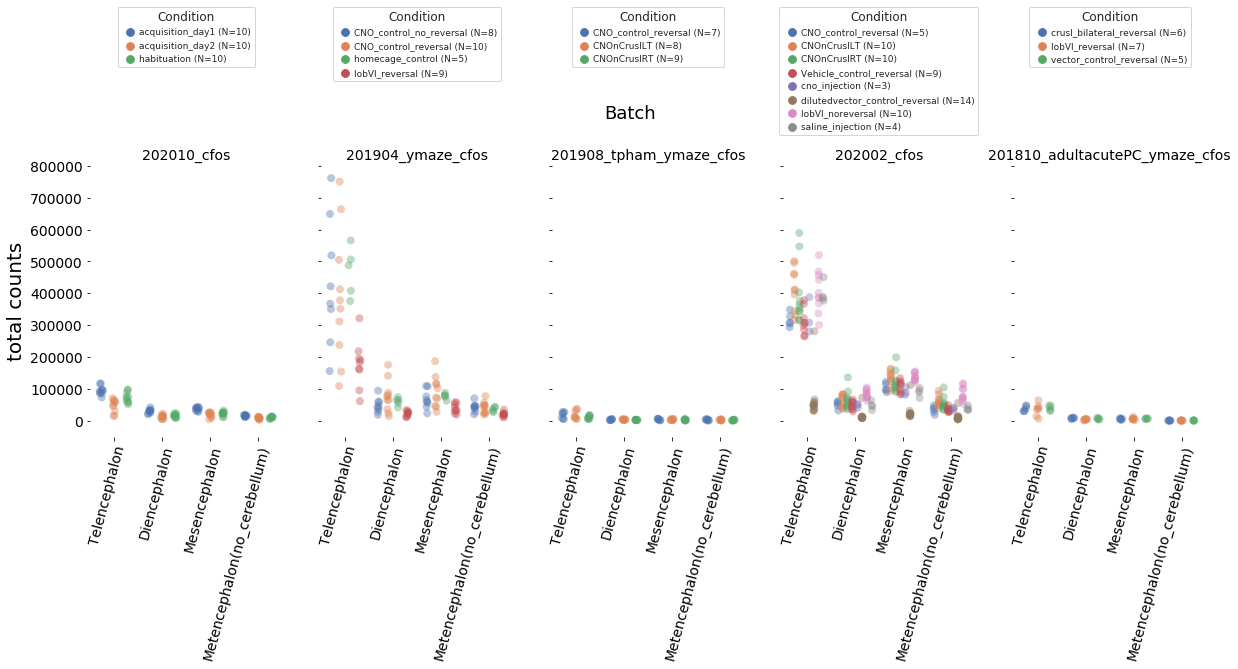

In [44]:
# bdict = {
#     'Telencephalon':["Olfactory areas","Isocortex","Cortical subplate","Hippocampal formation","Cerebral nuclei"],
#     'Diencephalon':['Interbrain'],
#     'Mesencephalon':['Midbrain','Hindbrain'],
#         }
bdict = {
    'Telencephalon':["Olfactory areas","Isocortex","Cortical subplate","Hippocampal formation","Cerebral nuclei"],
    'Diencephalon':['Interbrain'],
    'Mesencephalon':['Midbrain',],
    'Metencephalon(no_cerebellum)':['Hindbrain']
        }
make_stripplot_fixed_batch(brain_division_dict=bdict,           
                                     count_type='total',
                                     savename=None)

### Fixed batch fractional counts (Telencephalon, Diencephalon, Mesencephalon) 

y-axis is on same scale in all subplots

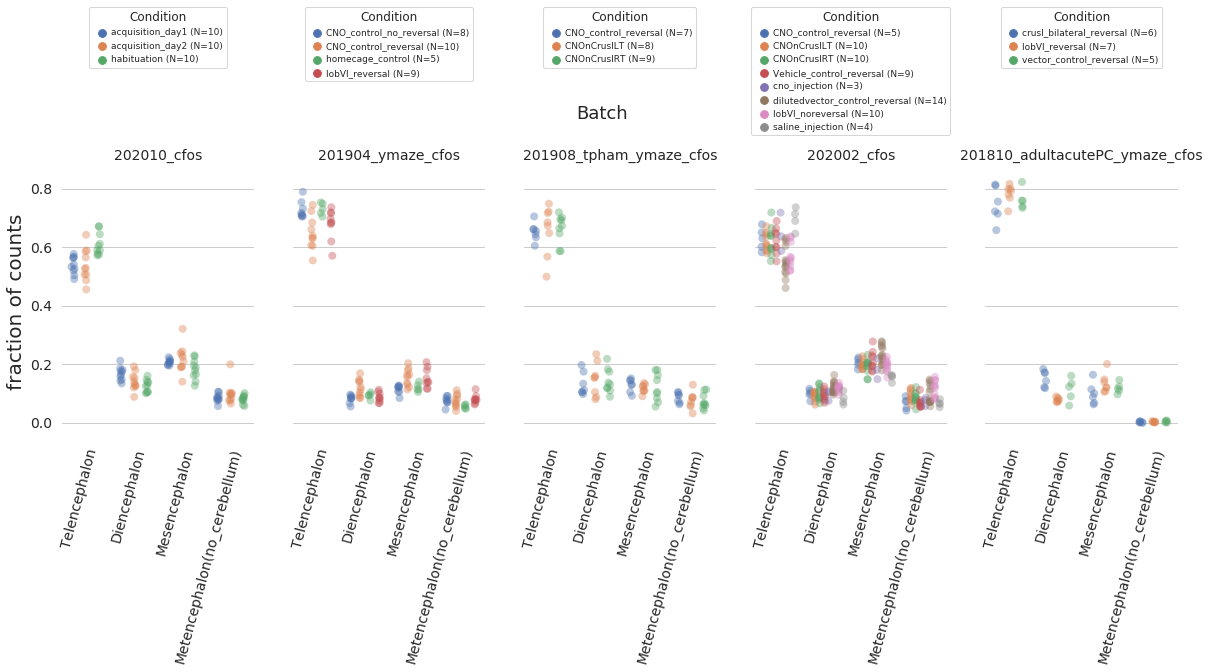

In [45]:
bdict = {
    'Telencephalon':["Olfactory areas","Isocortex","Cortical subplate","Hippocampal formation","Cerebral nuclei"],
    'Diencephalon':['Interbrain'],
    'Mesencephalon':['Midbrain',],
    'Metencephalon(no_cerebellum)':['Hindbrain']
        }
make_stripplot_fixed_batch(brain_division_dict=bdict,           
                                     count_type='frac',
                                     savename=None)

# Fixed batch plots (subregions of Telencephalon, Diencephalon, Mesencephalon) <a class="anchor" id="fixed_batch_meddiv"></a>

### Fixed batch total counts (subregions of Telencephalon, Diencephalon, Mesencephalon)

y-axis is on same scale in all subplots

In the brain region labels:
- T = Telencephalon
- D = Diencephalon
- Mes = Mesencephalon
- Met = Metencephalon

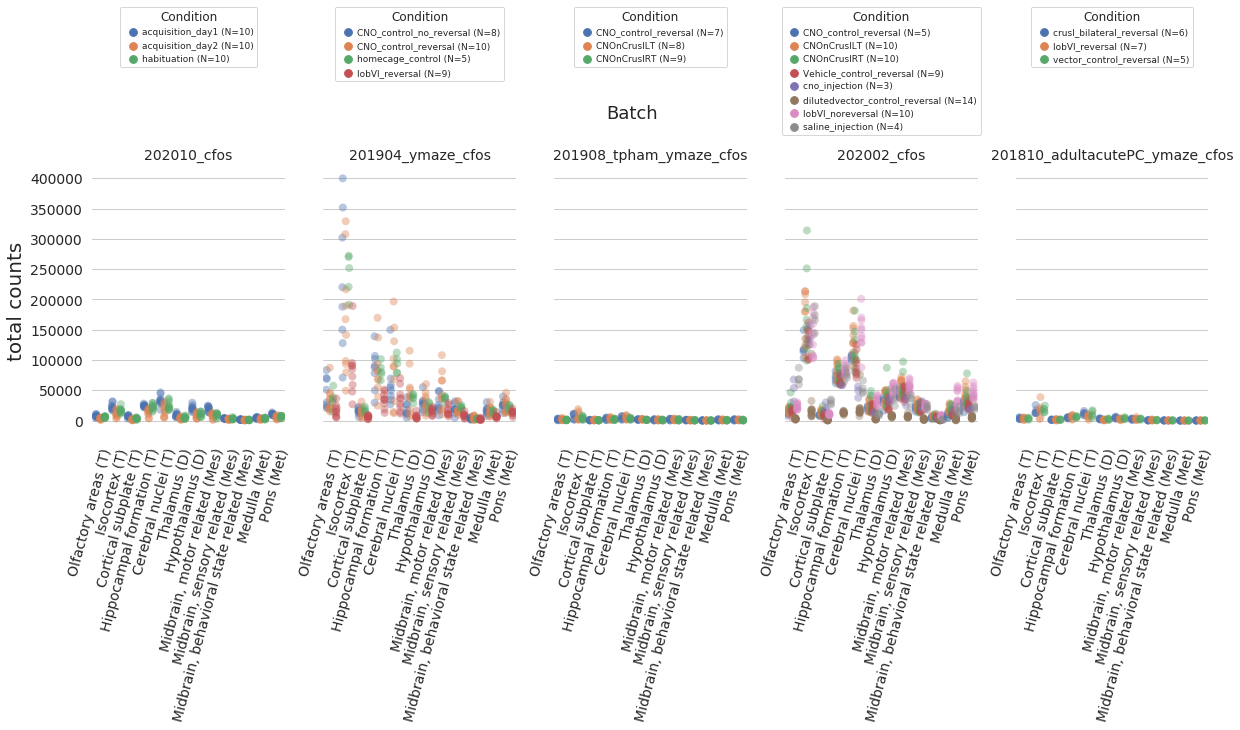

In [46]:
bdict_subregions = {
    "Olfactory areas (T)":["Olfactory areas"],
    "Isocortex (T)":["Isocortex",],
    "Cortical subplate (T)":["Cortical subplate",],
    "Hippocampal formation (T)":["Hippocampal formation",],
    "Cerebral nuclei (T)":["Cerebral nuclei",],
    'Thalamus (D)':["Thalamus",],
    'Hypothalamus (D)':['Hypothalamus'],
    'Midbrain, motor related (Mes)':['Midbrain, motor related'],
    'Midbrain, sensory related (Mes)':['Midbrain, sensory related'],
    'Midbrain, behavioral state related (Mes)':['Midbrain, behavioral state related'],
    'Medulla (Met)':['Medulla'],
    'Pons (Met)':['Pons'],
    }
make_stripplot_fixed_batch(brain_division_dict=bdict_subregions,           
                                     count_type='total',
                                     savename=None)

### Fixed batch fractional counts (subregions of Telencephalon, Diencephalon, Mesencephalon)

y-axis is on same scale in all subplots

In the brain region labels:
- T = Telencephalon
- D = Diencephalon
- Mes = Mesencephalon
- Met = Metencephalon

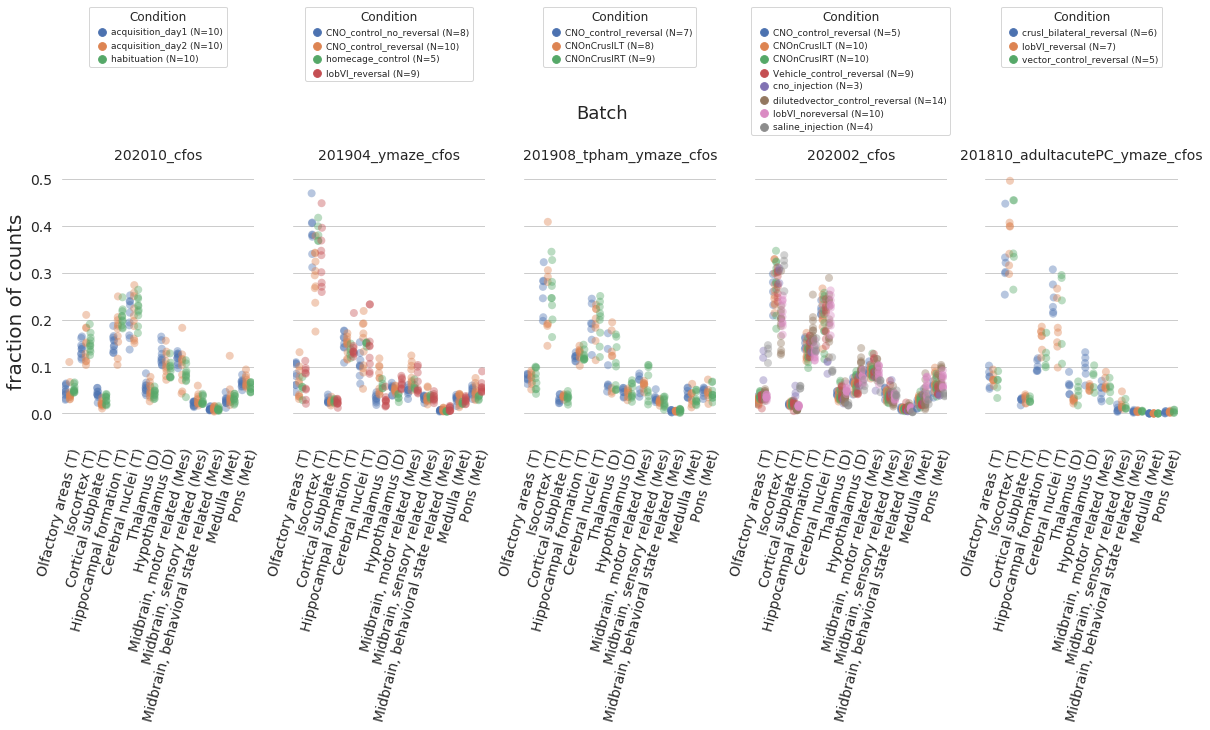

In [47]:
bdict_subregions = {
    "Olfactory areas (T)":["Olfactory areas"],
    "Isocortex (T)":["Isocortex",],
    "Cortical subplate (T)":["Cortical subplate",],
    "Hippocampal formation (T)":["Hippocampal formation",],
    "Cerebral nuclei (T)":["Cerebral nuclei",],
    'Thalamus (D)':["Thalamus",],
    'Hypothalamus (D)':['Hypothalamus'],
    'Midbrain, motor related (Mes)':['Midbrain, motor related'],
    'Midbrain, sensory related (Mes)':['Midbrain, sensory related'],
    'Midbrain, behavioral state related (Mes)':['Midbrain, behavioral state related'],
    'Medulla (Met)':['Medulla'],
    'Pons (Met)':['Pons'],
    }
make_stripplot_fixed_batch(brain_division_dict=bdict_subregions,           
                                     count_type='frac',
                                     savename=None)

# Fixed condition plots (Telencephalon, Diencephalon, Mesencephalon) <a class="anchor" id="fixed_condition_bigdiv"></a>

### Fixed condition total counts (Telencephalon, Diencephalon, Mesencephalon) 
y-axis is on same scale in all subplots

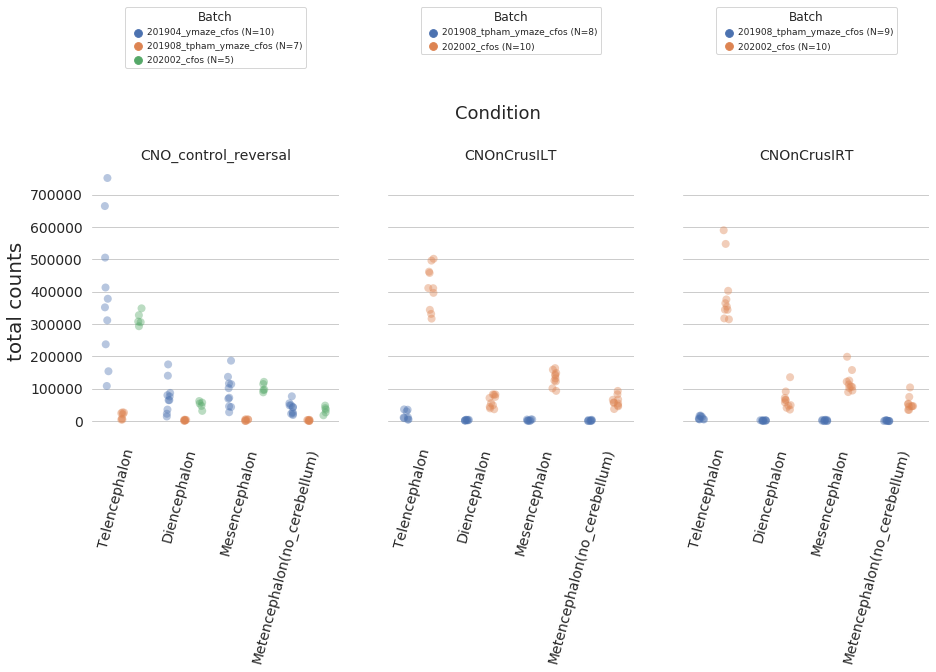

In [48]:
bdict = {
    'Telencephalon':["Olfactory areas","Isocortex","Cortical subplate","Hippocampal formation","Cerebral nuclei"],
    'Diencephalon':['Interbrain'],
    'Mesencephalon':['Midbrain',],
    'Metencephalon(no_cerebellum)':['Hindbrain']
        }
make_stripplot_fixed_condition(brain_division_dict=bdict,           
                                     count_type='total')

### Fixed condition fractional counts (Telencephalon, Diencephalon, Mesencephalon) 

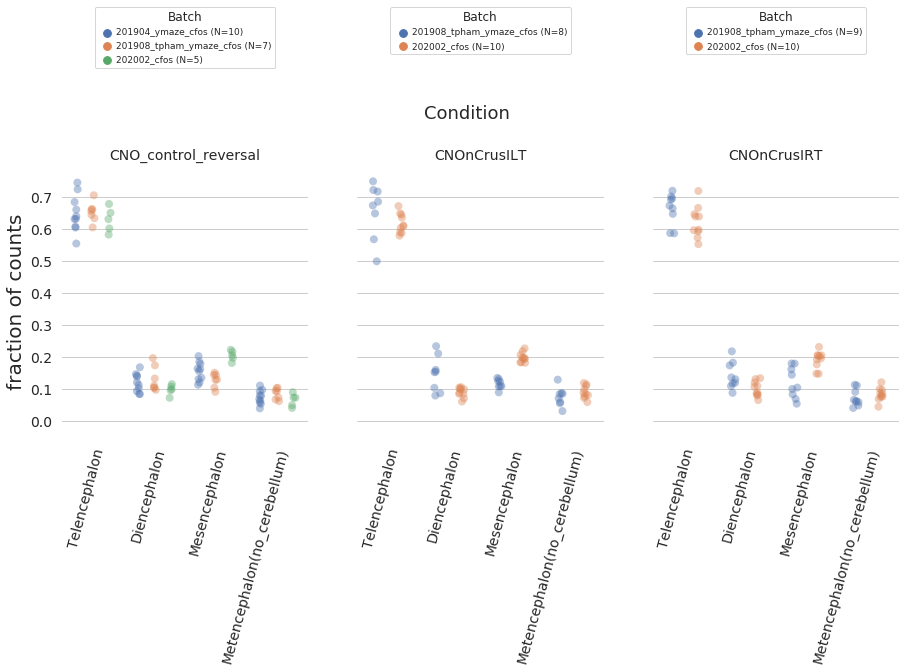

In [49]:
bdict = {
    'Telencephalon':["Olfactory areas","Isocortex","Cortical subplate","Hippocampal formation","Cerebral nuclei"],
    'Diencephalon':['Interbrain'],
    'Mesencephalon':['Midbrain',],
    'Metencephalon(no_cerebellum)':['Hindbrain']
        }
make_stripplot_fixed_condition(brain_division_dict=bdict,           
                                     count_type='frac')

# Fixed condition plots (subregions of Telencephalon, Diencephalon, Mesencephalon) <a class="anchor" id="fixed_condition_meddiv"></a>

### Fixed condition total counts (subregions of Telencephalon, Diencephalon, Mesencephalon)

y-axis is on same scale in all subplots

In the brain region labels:
- T = Telencephalon
- D = Diencephalon
- Mes = Mesencephalon
- Met = Metencephalon

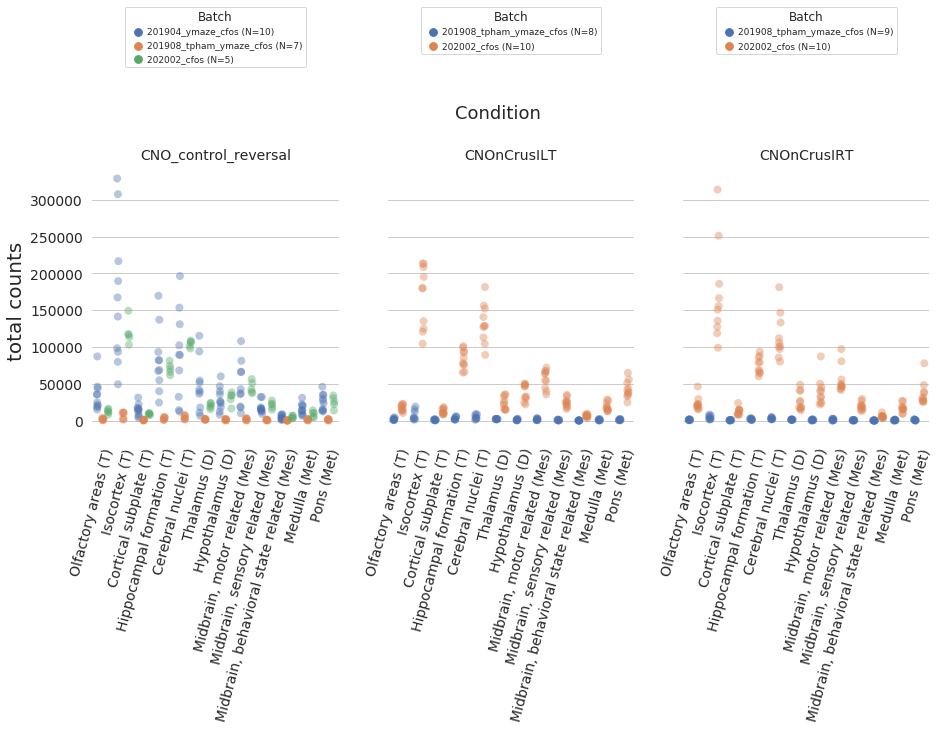

In [50]:
bdict_subregions = {
    "Olfactory areas (T)":["Olfactory areas"],
    "Isocortex (T)":["Isocortex",],
    "Cortical subplate (T)":["Cortical subplate",],
    "Hippocampal formation (T)":["Hippocampal formation",],
    "Cerebral nuclei (T)":["Cerebral nuclei",],
    'Thalamus (D)':["Thalamus",],
    'Hypothalamus (D)':['Hypothalamus'],
    'Midbrain, motor related (Mes)':['Midbrain, motor related'],
    'Midbrain, sensory related (Mes)':['Midbrain, sensory related'],
    'Midbrain, behavioral state related (Mes)':['Midbrain, behavioral state related'],
    'Medulla (Met)':['Medulla'],
    'Pons (Met)':['Pons'],
    }
make_stripplot_fixed_condition(brain_division_dict=bdict_subregions,           
                                     count_type='total')

### Fixed condition fractional counts (subregions of Telencephalon, Diencephalon, Mesencephalon)

y-axis is on same scale in all subplots

In the brain region labels:
- T = Telencephalon
- D = Diencephalon
- Mes = Mesencephalon
- Met = Metencephalon

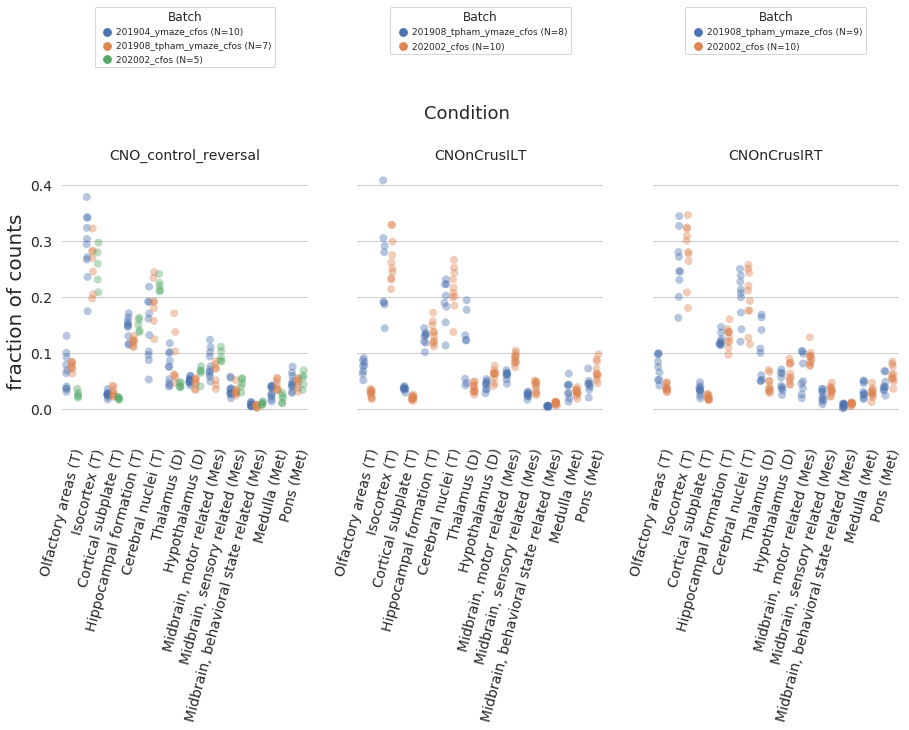

In [51]:
bdict_subregions = {
    "Olfactory areas (T)":["Olfactory areas"],
    "Isocortex (T)":["Isocortex",],
    "Cortical subplate (T)":["Cortical subplate",],
    "Hippocampal formation (T)":["Hippocampal formation",],
    "Cerebral nuclei (T)":["Cerebral nuclei",],
    'Thalamus (D)':["Thalamus",],
    'Hypothalamus (D)':['Hypothalamus'],
    'Midbrain, motor related (Mes)':['Midbrain, motor related'],
    'Midbrain, sensory related (Mes)':['Midbrain, sensory related'],
    'Midbrain, behavioral state related (Mes)':['Midbrain, behavioral state related'],
    'Medulla (Met)':['Medulla'],
    'Pons (Met)':['Pons'],
    }
make_stripplot_fixed_condition(brain_division_dict=bdict_subregions,           
                                     count_type='frac')

## Cell fractions

In [28]:
def make_all_division_df(brain_division_dict,count_type='frac'):
    """ 
    ---PURPOSE---
    Given a batch and condition create a pandas DataFrame
    containing columns: Brain, Batch, Condition and the subdivisions
    for all batches and conditions.
    ---INPUT---
    batch          The "experiment" column of the main dataframe
    condition      The "Condition" column of the main dataframe
    count_type     if 'frac' plots using fractional counts. 
                   if 'total' plots using total counts
    """
    df_list = []
    for ii,batch in enumerate(batches):
        # figure out which conditions were used in this batch
        condition_list = pivot_df['condition'][pivot_df[batch]>0]
        for condition in condition_list:
            counts_dict = get_counts_dict(brain_division_dict,batch,condition,count_type)

            counts_by_division = []
            for brain in counts_dict:
                division_dict = {'brain':brain}
                for division in counts_dict[brain]:
                    division_dict[division] = counts_dict[brain][division]
                counts_by_division.append(division_dict)
            df = pd.DataFrame(counts_by_division)
            df = df.assign(batch=batch,condition=condition)
            df_list.append(df)
    cdf = pd.concat(df_list)
    # reorder columns to be brain,batch,condition,fractions...
    cols = cdf.columns.tolist()
    newcols = cols[0:1] + cols[-2:] + cols[1:-2]
    cdf = cdf[newcols]
    return cdf

In [52]:
bdict = {
    'Telencephalon':["Olfactory areas","Isocortex","Cortical subplate","Hippocampal formation","Cerebral nuclei"],
    'Diencephalon':['Interbrain'],
    'Mesencephalon':['Midbrain',],
    'Metencephalon(no_cerebellum)':['Hindbrain']
        }
df = make_all_division_df(bdict,count_type='frac')

In [53]:
df

,brain,batch,condition,Telencephalon,Diencephalon,Mesencephalon,Metencephalon(no_cerebellum)
0,an011,202010_cfos,acquisition_day1,0.565555,0.159227,0.199942,0.075276
1,an012,202010_cfos,acquisition_day1,0.567072,0.144438,0.204193,0.084297
2,an013,202010_cfos,acquisition_day1,0.504236,0.181240,0.208506,0.106019
3,an014,202010_cfos,acquisition_day1,0.533377,0.185215,0.224087,0.057322
4,an015,202010_cfos,acquisition_day1,0.577020,0.134624,0.206436,0.081920
...,...,...,...,...,...,...,...
0,dadult_pc_crus1_1,201810_adultacutePC_ymaze_cfos,vector_control_reversal,0.758882,0.123070,0.110474,0.007574
1,dadult_pc_crus1_3,201810_adultacutePC_ymaze_cfos,vector_control_reversal,0.734586,0.160870,0.097173,0.007372
2,dadult_pc_crus1_4,201810_adultacutePC_ymaze_cfos,vector_control_reversal,0.740042,0.134174,0.124036,0.001748
3,dadult_pc_lob6_14,201810_adultacutePC_ymaze_cfos,vector_control_reversal,0.823287,0.058770,0.116767,0.001177


In [54]:
savename_bigdiv = '../results/fractional_counts_biggest_divisions.csv'
df.to_csv(savename_bigdiv)

In [55]:
bdict_subregions = {
    "Olfactory areas (T)":["Olfactory areas"],
    "Isocortex (T)":["Isocortex",],
    "Cortical subplate (T)":["Cortical subplate",],
    "Hippocampal formation (T)":["Hippocampal formation",],
    "Cerebral nuclei (T)":["Cerebral nuclei",],
    'Thalamus (D)':["Thalamus",],
    'Hypothalamus (D)':['Hypothalamus'],
    'Midbrain, motor related (Mes)':['Midbrain, motor related'],
    'Midbrain, sensory related (Mes)':['Midbrain, sensory related'],
    'Midbrain, behavioral state related (Mes)':['Midbrain, behavioral state related'],
    'Medulla (Met)':['Medulla'],
    'Pons (Met)':['Pons'],
    }
df_sub = make_all_division_df(bdict_subregions,count_type='frac')

In [56]:
df_sub

,brain,batch,condition,Olfactory areas (T),Isocortex (T),Cortical subplate (T),Hippocampal formation (T),Cerebral nuclei (T),Thalamus (D),Hypothalamus (D),"Midbrain, motor related (Mes)","Midbrain, sensory related (Mes)","Midbrain, behavioral state related (Mes)",Medulla (Met),Pons (Met)
0,an011,202010_cfos,acquisition_day1,0.045715,0.164140,0.035058,0.128884,0.231065,0.054633,0.115660,0.120819,0.017196,0.006320,0.022012,0.058496
1,an012,202010_cfos,acquisition_day1,0.031241,0.160787,0.038828,0.129758,0.239665,0.049446,0.103449,0.127608,0.015669,0.014314,0.032251,0.056982
2,an013,202010_cfos,acquisition_day1,0.046987,0.118943,0.054354,0.134785,0.187898,0.038775,0.156386,0.124733,0.013549,0.009428,0.031359,0.082803
3,an014,202010_cfos,acquisition_day1,0.062216,0.145105,0.054653,0.144421,0.166485,0.085602,0.113330,0.132875,0.024843,0.008902,0.011976,0.049591
4,an015,202010_cfos,acquisition_day1,0.051885,0.137911,0.039998,0.156739,0.238473,0.043199,0.102620,0.107473,0.025040,0.007930,0.025637,0.063096
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,dadult_pc_crus1_1,201810_adultacutePC_ymaze_cfos,vector_control_reversal,0.055238,0.333885,0.024797,0.098590,0.288913,0.048024,0.081945,0.045210,0.009670,0.005730,0.000034,0.007964
1,dadult_pc_crus1_3,201810_adultacutePC_ymaze_cfos,vector_control_reversal,0.071521,0.263941,0.031455,0.118342,0.294966,0.068299,0.102566,0.026535,0.010544,0.004003,0.000000,0.007830
2,dadult_pc_crus1_4,201810_adultacutePC_ymaze_cfos,vector_control_reversal,0.071443,0.341041,0.026329,0.102998,0.240977,0.056602,0.085322,0.055961,0.011587,0.005892,0.000000,0.001849
3,dadult_pc_lob6_14,201810_adultacutePC_ymaze_cfos,vector_control_reversal,0.090208,0.454246,0.036508,0.129612,0.148232,0.017173,0.044132,0.058153,0.016678,0.003830,0.000037,0.001191


In [58]:
savename_meddiv = '../results/fractional_counts_subdivisions.csv'
df_sub.to_csv(savename_meddiv)